In [55]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 17})
import folium
import re
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostRegressor
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

class DataFrame(object):

    def __init__(self,file_path):
        """Create df object
        Parameters
        ----------
        file_path: takes in a file path to raw data
        """
        self.file_path = file_path
        
    def clean(self):
        '''
        Parameters
            self: self
        Returns
            a cleaned df
        '''
        df = pd.read_csv(self.file_path,encoding='latin1')
        df.dropna(inplace=True)
        df.drop(['permalink','region','founded_month','founded_quarter'],axis=1,inplace=True)
        df['founded_at'] = pd.to_datetime(df['founded_at'],errors='coerce')
        df['first_funding_at']= pd.to_datetime(df['first_funding_at'],errors='coerce')
        df['last_funding_at']= pd.to_datetime(df['first_funding_at'],errors='coerce')
        df['founded_year'] = df['founded_year'].astype('int64')
        df.drop(df[df['country_code']=='CAN'].index,inplace=True)
        df['funding_total_usd'] = df[' funding_total_usd '].apply(lambda x: x.replace(' ',''))\
            .apply(lambda x: x.replace(',',''))
        df['funding_total_usd'] = df['funding_total_usd'].apply(lambda x: x.replace('-','0'))
        df['funding_total_usd'] = df['funding_total_usd'].astype('int64')
        df['market'] = df[' market '].apply(lambda x: x.replace(' ',''))
        df.drop([' market ',' funding_total_usd ','country_code','homepage_url','name','city','last_funding_at', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H','category_list'],axis=1,inplace=True)
        return df

def create_pie_charts(df,column,column_val,target):
    '''
    Parameters
    df: Cleaned data frame
    column: column of data frame used to split data as string
    column_val: Value we are looking for in column as string
    target: The target values we are trying to predict
    Returns
    a saved image in the images folder
    '''
    column_val_title = ' '.join(re.findall('[A-Z][^A-Z]*',column))
    pie_df = df[df[column]==column_val][target].value_counts().rename_axis(target)\
        .reset_index(name='counts')
    pie_df['pct'] = pie_df['counts']/len(pie_df)
    labels=pie_df[target]
    fig, ax = plt.subplots(figsize=(14,7))
    ax.pie(pie_df['pct'], labels=labels, \
        autopct='%1.1f%%',shadow=False, startangle=50)
    ax.axis('equal')
    ax.set_title('Status of Equity Crowd Funding',fontweight='bold')
    plt.savefig(f'../images/{column}_pie.png',dpi=500)
    plt.close(fig='all')


    #intialized dataframe class and build features
    intial_df = DataFrame('../../../Downloads/investments_VC.csv').clean()
    clean_feat_df=feature_engineer(intial_df)

In [56]:
clean_feat_df.loc[:,'seed':'product_crowdfunding'] = clean_feat_df.loc[:,'seed':'product_crowdfunding']\
        .apply(lambda x: x>0).astype('str')

In [57]:
clean_feat_df

,status,state_code,funding_rounds,founded_at,founded_year,first_funding_at,seed,venture,equity_crowdfunding,undisclosed,...,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,funding_total_usd,market,time_to_funding
0,acquired,NY,1.0,2012-06-01,2012,2012-06-30,True,False,False,False,...,False,False,False,False,False,False,False,1750000,Other,29.0
8,operating,IL,1.0,2010-01-01,2010,2014-07-24,False,False,False,False,...,False,False,False,False,False,False,False,0,Software,1665.0
12,operating,CA,1.0,1986-01-01,1986,2010-08-19,False,False,False,False,...,False,False,False,False,False,False,False,0,HealthandWellness,8996.0
13,operating,NJ,1.0,1984-01-01,1984,2011-03-02,False,False,False,False,...,False,False,False,False,False,False,False,1750000,HealthandWellness,9922.0
16,operating,MD,4.0,2001-01-01,2001,2009-06-18,False,False,False,False,...,False,False,False,False,False,False,False,2050000,E-Commerce,3090.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49425,operating,PA,1.0,2014-01-01,2014,2014-10-14,False,True,False,False,...,False,False,False,False,False,False,False,13000000,Other,286.0
49426,operating,CA,9.0,2007-07-01,2007,2007-01-01,False,True,False,False,...,False,False,False,False,False,False,False,866550786,Other,181.0
49427,operating,MD,1.0,2008-01-01,2008,2010-09-09,False,True,False,False,...,False,False,False,False,False,False,False,25000000,Biotechnology,982.0
49429,operating,MO,4.0,1998-01-01,1998,2010-01-29,False,True,False,False,...,False,True,False,False,False,False,False,34275015,Biotechnology,4411.0


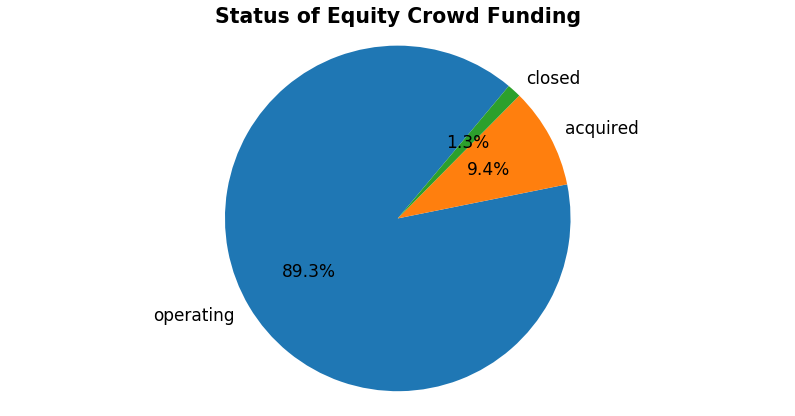

In [65]:
create_pie_charts(clean_feat_df,'private_equity','True','status')

In [26]:
clean_feat_df['equity_crowdfunding'].value_counts()

False    20624
True       238
Name: equity_crowdfunding, dtype: int64

In [31]:
clean_feat_df.loc[:,'seed':'product_crowdfunding']

,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding
0,True,False,False,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,False,False,False
12,False,False,False,False,False,False,False,False,False,False,False,False,False
13,False,False,False,False,True,False,False,False,False,False,False,False,False
16,False,False,False,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49425,False,True,False,False,False,False,False,False,False,False,False,False,False
49426,False,True,False,False,False,False,False,False,False,False,False,False,False
49427,False,True,False,False,False,False,False,False,False,False,False,False,False
49429,False,True,False,False,False,False,False,True,False,False,False,False,False
